# Data Prep & Modeling
## Filtering

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

marte_raw = pd.read_csv('marte_vs_nlwest_19_22.csv',
                        usecols=['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'zone', 'des', 'p_throws', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name', 'spin_axis'])

# rename the primary response variable
marte_raw.rename(columns={'estimated_woba_using_speedangle': 'xwOBA'}, inplace=True)
print(f"data-set shape prior to filtering: {marte_raw.shape}")

# filter sacrifice events; if woba_denom is NaN, then sacrifice event
marte_raw.dropna(axis='rows', subset=['woba_denom'], how='any', inplace=True)
print(f"data-set shape after to filtering sac hits: {marte_raw.shape}")

# filter missing observation data
marte_raw.dropna(axis='rows', subset=['release_spin_rate', 'spin_axis'], how='any', inplace=True)
print(f"data-set shape after to filtering missing spin observations: {marte_raw.shape}")

data-set shape prior to filtering: (867, 30)
data-set shape after to filtering sac hits: (865, 30)
data-set shape after to filtering missing spin observations: (859, 30)


- release_speed
    - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
- release_pos_x
    - horizontal Release Position of the ball measured in feet from the catcher's perspective.
- release_pos_z
    - Vertical Release Position of the ball measured in feet from the catcher's perspective.
- plate_x
    - Horizontal position of the ball when it crosses home plate from the catcher's perspective.
- plate_z
    - Vertical position of the ball when it crosses home plate from the catcher's perspective.
- pitcher
    - MLB Player Id tied to the play event.
- zone
    - Zone location of the ball when it crosses the plate from the catcher's perspective.
- pfx_x
    - Horizontal movement in feet from the catcher's perspective.
- pfx_z
    - Vertical movement in feet from the catcher's perpsective.
- effective_speed
    - Derived speed based on the the extension of the pitcher's release.
- release_spin
    - Spin rate of pitch tracked by Statcast.
- spin_axis
    - The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball

## Filtering ext., Computed Features, NaN Conversions

In [4]:
import numpy as np
import math

# filter raw set with proposed model metrics
marte_vs = marte_raw.drop(columns=['game_date', 'release_pos_x', 'release_pos_z', 'des', 'bb_type', 'balls', 'strikes', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_extension', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])
print(f"new data-set shape after to filtering for proper metrics: {marte_vs.shape}")

# vectorize the horizontal & vertical movement using pythagorean theorem
marte_vs['pfx_v'] = np.sqrt(marte_vs.pfx_x ** 2 + marte_vs.pfx_z ** 2)

print(f"number of NaN xwOBA PAs prior to conversion: {marte_vs.xwOBA.isnull().sum()}")

# convert xwOBA stat to 0.0 for strikeouts
# if the xwOBA stat is NaN & a strikeout, then need to use the woba_value

marte_vs['xwOBA'] = marte_vs.apply(lambda x: x.woba_value if (math.isnan(x.xwOBA) and x.woba_value == 0.0) else x.xwOBA, axis=1)

# filter out walks, dropped 54 walks
marte_vs.dropna(axis='rows', subset=['xwOBA'], how='any', inplace=True)
print(f"data-set shape after to filtering walks: {marte_vs.shape}")

# reorder columns for logical readability
marte_vs = marte_vs.reindex(columns=['xwOBA', 'woba_value','game_year', 'pitcher', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'zone', 'pfx_x', 'pfx_z', 'pfx_v'])

print(marte_vs.head())

new data-set shape after to filtering for proper metrics: (859, 12)
number of NaN xwOBA PAs prior to conversion: 184
data-set shape after to filtering walks: (805, 13)
   xwOBA  woba_value  game_year  pitcher p_throws pitch_type  release_speed  \
0  0.709         0.9       2022   596001        R         SI           92.9   
1  0.262         0.0       2022   596001        R         SI           92.6   
2  0.231         0.0       2022   596001        R         SI           93.0   
3  0.117         0.0       2022   518397        L         SI           93.3   
4  0.438         0.0       2022   502171        R         SI           94.1   

   release_spin_rate  spin_axis  zone  pfx_x  pfx_z     pfx_v  
0             2303.0      211.0     5  -1.15   0.68  1.336001  
1             2316.0      204.0     9  -1.05   0.80  1.320038  
2             2245.0      219.0     8  -1.13   0.79  1.378768  
3             2189.0      135.0     8   1.19   0.28  1.222497  
4             2126.0      221.0     4

## Transformations
### Dummies
A common mistake is to apply transformations to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set.

In [5]:
marte_vs_trx = pd.get_dummies(data=marte_vs, columns=['pitch_type', 'zone'])
marte_vs_trx = pd.get_dummies(data=marte_vs_trx, columns=['p_throws'], drop_first=True)
marte_vs_trx.head()

,xwOBA,woba_value,game_year,pitcher,release_speed,release_spin_rate,spin_axis,pfx_x,pfx_z,pfx_v,...,zone_5,zone_6,zone_7,zone_8,zone_9,zone_11,zone_12,zone_13,zone_14,p_throws_R
0,0.709,0.9,2022,596001,92.9,2303.0,211.0,-1.15,0.68,1.336001,...,1,0,0,0,0,0,0,0,0,1
1,0.262,0.0,2022,596001,92.6,2316.0,204.0,-1.05,0.80,1.320038,...,0,0,0,0,1,0,0,0,0,1
2,0.231,0.0,2022,596001,93.0,2245.0,219.0,-1.13,0.79,1.378768,...,0,0,0,1,0,0,0,0,0,1
3,0.117,0.0,2022,518397,93.3,2189.0,135.0,1.19,0.28,1.222497,...,0,0,0,1,0,0,0,0,0,0
4,0.438,0.0,2022,502171,94.1,2126.0,221.0,-1.34,0.45,1.413542,...,0,0,0,0,0,0,0,0,0,1


### Feature and output transformations

In [23]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = marte_vs_trx.drop(columns=['xwOBA', 'game_year', 'pitcher'])  # remove response var and extra features
y = marte_vs.xwOBA
# split data into training and testing sets

X = sm.add_constant(X)   # only needed for sm (not smf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1642)

print('Train set shape\n', X_train.shape, y_train.shape)
print('Test set shape\n', X_test.shape, y_test.shape)
print('---')

# transform numerical data
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

num_feats = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pfx_x', 'pfx_z']
# used for positive values
pt = PowerTransformer()
# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx
############################
# # normalize output
mms = MinMaxScaler().fit(y_train.to_numpy().reshape(-1, 1))
y_train_trx = pd.Series(map(lambda x: x[0], mms.transform(y_train.to_numpy().reshape(-1, 1))), index=y_train.index)
# normalize on the test output, converted to a pandas.Series with the original indicies
y_test_trx = pd.Series(map(lambda x: x[0], mms.transform(y_test.to_numpy().reshape(-1, 1))), index=y_test.index)

# drop woba_value from feature after use in normalizing response
X_train.drop(columns=['woba_value'], inplace=True)
X_test.drop(columns=['woba_value'], inplace=True)

print('Train trx set shape\n', X_train_trx.shape, y_train_trx.shape)
print('Test trx set shape\n', X_test_trx.shape, y_test_trx.shape)
print('---')

print(X_train.head())

Train set shape
 (523, 31) (523,)
Test set shape
 (282, 31) (282,)
---
Train trx set shape
 (523, 6) (523,)
Test trx set shape
 (282, 6) (282,)
---
     const  release_speed  release_spin_rate  spin_axis     pfx_x     pfx_z  \
203    1.0      -0.920315          -2.124581   0.972639 -1.157566 -0.733552   
148    1.0      -0.057624          -1.383543   0.766952 -1.297206 -0.910677   
33     1.0       1.316512           0.731352  -0.457234  0.810969  1.284089   
207    1.0       0.839384          -0.674438   0.698941 -0.881985  0.691394   
205    1.0      -0.261046           1.063236   0.296934  0.627254 -0.257401   

        pfx_v  pitch_type_CH  pitch_type_CS  pitch_type_CU  ...  zone_5  \
203 -0.441333              0              0              0  ...       0   
148 -0.298451              0              0              0  ...       0   
33   0.836550              0              0              0  ...       0   
207  0.529671              0              0              0  ...       0   
20

## Modeling
### Naive Model
*Note: did not transform the output for the naive model.

In [22]:
# Marte's xwOBA for last 4 seasons ('19-'22) == .348 || without walks xwOBA == .305
from sklearn.metrics import *

print(y.mean())
y_same_xwOBA = pd.Series(.305, index=range(0, y_train.size))
# if squared is false then rmse
naive_rmse = mean_squared_error(y_true=y_train, y_pred=y_same_xwOBA, squared=False)
print(f"naive mse: {naive_rmse}")

naive_r2 = r2_score(y_true=y_train, y_pred=y_same_xwOBA)
print(f"naive r2 score: {naive_r2}")

0.3059652173913044
naive mse: 0.3831872723090576
naive r2 score: -0.0029234574834715588


### NN
#### Model 1

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout, BatchNormalization


# normalizer = preprocessing.Normalization()
# normalizer.adapt(np.array(train_features))
X_1 = X_train.release_spin_rate
X_1_test = X_test.release_spin_rate
number_of_inputs = 1  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

print("Fit model on training data")
history = model.fit(
    X_1,
    y_train_trx,
    batch_size=42,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_1_test, y_test_trx),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_1_test, y_test_trx, batch_size=42)
print("test loss, test acc:", results)

print("Generate predictions for test data")
predictions = model.predict(X_1_test)
print("predictions shape:", predictions.shape)

X1_rmse = mean_squared_error(y_true=y_test_trx, y_pred=predictions, squared=False)
print(f"mse: {X1_rmse}")

X1_r2 = r2_score(y_true=y_test_trx, y_pred=predictions)
print(f"r2 score: {X1_r2}")

Fit model on training data
Epoch 1/100
13/13 [==============================] - 1s 15ms/step - loss: 0.0790 - root_mean_squared_error: 0.2811 - mean_absolute_error: 0.2042 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1956 - val_mean_absolute_error: 0.1462
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0481 - root_mean_squared_error: 0.2192 - mean_absolute_error: 0.1569 - val_loss: 0.0263 - val_root_mean_squared_error: 0.1622 - val_mean_absolute_error: 0.1240
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0405 - root_mean_squared_error: 0.2012 - mean_absolute_error: 0.1508 - val_loss: 0.0259 - val_root_mean_squared_error: 0.1608 - val_mean_absolute_error: 0.1269
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.0397 - root_mean_squared_error: 0.1992 - mean_absolute_error: 0.1526 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1612 - val_mean_absolute_error: 0.1300
Epoch 5/100
13/13 [=============

#### NN2 -- Higher Fidelity Model

In [29]:
from tensorflow_addons.metrics import RSquare

X_feats2 = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL', 'zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12', 'zone_13', 'zone_14', 'p_throws_R']
X_full = X_train[X_feats2]
X_full_test = X_test[X_feats2]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(16, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=26,
    epochs=100,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=26)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for test samples")
X2_predictions = model.predict(X_full_test)
print("predictions shape:", predictions.shape)

X2_rmse = mean_squared_error(y_true=y_test_trx, y_pred=X2_predictions, squared=False)
print(f"mse: {X2_rmse}")

X2_r2 = r2_score(y_true=y_test_trx, y_pred=X2_predictions)
print(f"r2 score: {X2_r2}")

Fit model on training data
Epoch 1/100
21/21 [==============================] - 1s 12ms/step - loss: 0.0731 - root_mean_squared_error: 0.2703 - mean_absolute_error: 0.2129 - r_square: -0.9053 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2031 - val_mean_absolute_error: 0.1613 - val_r_square: -0.6590
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0515 - root_mean_squared_error: 0.2270 - mean_absolute_error: 0.1774 - r_square: -0.3438 - val_loss: 0.0348 - val_root_mean_squared_error: 0.1866 - val_mean_absolute_error: 0.1471 - val_r_square: -0.4013
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0461 - root_mean_squared_error: 0.2148 - mean_absolute_error: 0.1679 - r_square: -0.2035 - val_loss: 0.0325 - val_root_mean_squared_error: 0.1802 - val_mean_absolute_error: 0.1424 - val_r_square: -0.3062
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0433 - root_mean_squared_error: 0.2080 - mean_absolute_error

In [31]:
from tensorflow.keras import regularizers

X_feats3 = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL']
X_full = X_train[X_feats3]
X_full_test = X_test[X_feats3]
number_of_inputs = X_full.shape[1]  # number of features
model = keras.Sequential([layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(), input_dim=number_of_inputs),
                          layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2()),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=32,
    epochs=400,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=32)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for test samples")
X3_predictions = model.predict(X_full_test[X_feats3])
print("predictions shape:", predictions.shape)

X3_rmse = mean_squared_error(y_true=y_test_trx, y_pred=X3_predictions, squared=False)
print(f"mse: {X3_rmse}")

X3_r2 = r2_score(y_true=y_test_trx, y_pred=X3_predictions)
print(f"r2 score: {X3_r2}")

Fit model on training data
Epoch 1/400
17/17 [==============================] - 1s 19ms/step - loss: 3.6910 - root_mean_squared_error: 0.2197 - mean_absolute_error: 0.1598 - r_square: -0.2590 - val_loss: 3.4246 - val_root_mean_squared_error: 0.1681 - val_mean_absolute_error: 0.1303 - val_r_square: -0.1367
Epoch 2/400
17/17 [==============================] - 0s 4ms/step - loss: 3.2452 - root_mean_squared_error: 0.2052 - mean_absolute_error: 0.1581 - r_square: -0.0982 - val_loss: 3.0012 - val_root_mean_squared_error: 0.1614 - val_mean_absolute_error: 0.1246 - val_r_square: -0.0482
Epoch 3/400
17/17 [==============================] - 0s 3ms/step - loss: 2.8370 - root_mean_squared_error: 0.2007 - mean_absolute_error: 0.1517 - r_square: -0.0502 - val_loss: 2.6120 - val_root_mean_squared_error: 0.1606 - val_mean_absolute_error: 0.1262 - val_r_square: -0.0381
Epoch 4/400
17/17 [==============================] - 0s 4ms/step - loss: 2.4616 - root_mean_squared_error: 0.1981 - mean_absolute_error

#### Hyper sweep

In [11]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_and_compile_model():
    # create model
    model = keras.Sequential([layers.Dense(16, activation='relu', input_dim=number_of_inputs),
                              layers.Dense(16, activation='relu'),
                              layers.Dense(1, activation='linear') ]) # output layer for regression

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])
    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
batch_size = [8, 16, 32, 64, 128]
epochs = [10, 50, 250, 1250]

param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

grid_result = grid.fit(X_full, y_train_trx)

/var/folders/nz/57m0v30s0kqdtdm5876x20qw0000gn/T/ipykernel_13941/1658499985.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)
2022-11-30 22:15:49.027869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-30 22:15:49.027908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with 

6/6 [==============================] - 0s 550us/step


In [12]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

Best: -0.255660 using {'batch_size': 8, 'epochs': 10}
train accuracy -0.255660 for: {'batch_size': 8, 'epochs': 10}
train accuracy -0.255660 for: {'batch_size': 8, 'epochs': 50}
train accuracy -0.255660 for: {'batch_size': 8, 'epochs': 250}
train accuracy -0.255662 for: {'batch_size': 8, 'epochs': 1250}
train accuracy -0.255660 for: {'batch_size': 16, 'epochs': 10}
train accuracy -0.255660 for: {'batch_size': 16, 'epochs': 50}
train accuracy -0.255660 for: {'batch_size': 16, 'epochs': 250}
train accuracy -0.255661 for: {'batch_size': 16, 'epochs': 1250}
train accuracy -0.255660 for: {'batch_size': 32, 'epochs': 10}
train accuracy -0.255660 for: {'batch_size': 32, 'epochs': 50}
train accuracy -0.255660 for: {'batch_size': 32, 'epochs': 250}
train accuracy -0.255664 for: {'batch_size': 32, 'epochs': 1250}
train accuracy -0.255680 for: {'batch_size': 64, 'epochs': 10}
train accuracy -0.255660 for: {'batch_size': 64, 'epochs': 50}
train accuracy -0.255660 for: {'batch_size': 64, 'epochs': 

In [13]:
def create_and_compile_model(num_neurons, num_layers):
    # create model
    model = keras.Sequential()
    model.add(Dense(num_neurons, input_dim=number_of_inputs, activation='relu'))

    if num_layers > 0:

        while num_layers > 0:
            model.add(Dense(num_neurons, activation='relu'))
            num_layers=num_layers-1


    model.add(Dense(1, activation='linear')) # output layer for regression

    # Compile model
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

    print(model.summary())
    print('--')

    return model

model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)

# define the grid search parameters
num_neurons_grid = [4, 8, 16]
num_layers_grid = [1, 2, 3, 4]

param_grid = dict(num_neurons=num_neurons_grid, num_layers=num_layers_grid)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3)

grid_result = grid.fit(X_full, y_train_trx)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 4)                 56        
                                                                 
 dense_43 (Dense)            (None, 4)                 20        
                                                                 
 dense_44 (Dense)            (None, 1)                 5         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 4)                 56        
                                                                 
 dense_34 (Dense)            (None

/var/folders/nz/57m0v30s0kqdtdm5876x20qw0000gn/T/ipykernel_13941/3761777028.py:25: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_and_compile_model, verbose=0)


None
--
1/6 [====>.........................] - ETA: 0sNone
--
6/6 [==============================] - 0s 1ms/step
None
--
6/6 [==============================] - 0s 1ms/step
None
--
6/6 [==============================] - 0s 1ms/step
None
--
6/6 [==============================] - 0s 1ms/step
None
--
1/6 [====>.........................] - ETA: 0sNone
--
6/6 [==============================] - 0s 1ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                224       
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 513
Trainable params: 513
Non-tra

In [14]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

params = grid_result.cv_results_['params']

for mean, param in zip(means, params):
    print("train accuracy %f for: %r" % (mean, param))

Best: -0.256242 using {'num_layers': 1, 'num_neurons': 8}
train accuracy -0.256614 for: {'num_layers': 1, 'num_neurons': 4}
train accuracy -0.256242 for: {'num_layers': 1, 'num_neurons': 8}
train accuracy -0.256343 for: {'num_layers': 1, 'num_neurons': 16}
train accuracy -0.256650 for: {'num_layers': 2, 'num_neurons': 4}
train accuracy -0.256452 for: {'num_layers': 2, 'num_neurons': 8}
train accuracy -0.256442 for: {'num_layers': 2, 'num_neurons': 16}
train accuracy -0.256545 for: {'num_layers': 3, 'num_neurons': 4}
train accuracy -0.256562 for: {'num_layers': 3, 'num_neurons': 8}
train accuracy -0.256655 for: {'num_layers': 3, 'num_neurons': 16}
train accuracy -0.256655 for: {'num_layers': 4, 'num_neurons': 4}
train accuracy -0.256655 for: {'num_layers': 4, 'num_neurons': 8}
train accuracy -0.256635 for: {'num_layers': 4, 'num_neurons': 16}


#### Combining Sweep
layers = 4
neurons = 8
batch_size = 8
epochs = 10

In [15]:
model = keras.Sequential([layers.Dense(8, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(8, activation='relu'),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=8,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/10
66/66 [==============================] - 1s 3ms/step - loss: 0.0481 - root_mean_squared_error: 0.2193 - mean_absolute_error: 0.1563 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1705 - val_mean_absolute_error: 0.1286
Epoch 2/10
66/66 [==============================] - 0s 1ms/step - loss: 0.0402 - root_mean_squared_error: 0.2005 - mean_absolute_error: 0.1496 - val_loss: 0.0288 - val_root_mean_squared_error: 0.1698 - val_mean_absolute_error: 0.1364
Epoch 3/10
66/66 [==============================] - 0s 1ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969 - mean_absolute_error: 0.1520 - val_loss: 0.0270 - val_root_mean_squared_error: 0.1642 - val_mean_absolute_error: 0.1306
Epoch 4/10
66/66 [==============================] - 0s 2ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - mean_absolute_error: 0.1493 - val_loss: 0.0264 - val_root_mean_squared_error: 0.1626 - val_mean_absolute_error: 0.1299
Epoch 5/10
66/66 [===================

In [16]:
factor = 0.01
model = keras.Sequential([layers.Dense(8, activation='relu', input_dim=number_of_inputs, kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(factor)),
                          layers.Dense(1, activation='linear') ]) # output layer for regression

model.compile(optimizer='adam',
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print("Fit model on training data")
history = model.fit(
    X_full,
    y_train_trx,
    batch_size=8,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_full_test, y_test_trx),
    callbacks=[callback]
)


# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_full_test, y_test_trx, batch_size=16)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 42 samples")
predictions = model.predict(X_full_test.iloc[:42,])
print("predictions shape:", predictions.shape)

Fit model on training data
Epoch 1/10
66/66 [==============================] - 1s 3ms/step - loss: 0.4158 - root_mean_squared_error: 0.2528 - mean_absolute_error: 0.1880 - val_loss: 0.3477 - val_root_mean_squared_error: 0.1769 - val_mean_absolute_error: 0.1329
Epoch 2/10
66/66 [==============================] - 0s 1ms/step - loss: 0.3317 - root_mean_squared_error: 0.2138 - mean_absolute_error: 0.1596 - val_loss: 0.2834 - val_root_mean_squared_error: 0.1662 - val_mean_absolute_error: 0.1299
Epoch 3/10
66/66 [==============================] - 0s 1ms/step - loss: 0.2727 - root_mean_squared_error: 0.2060 - mean_absolute_error: 0.1539 - val_loss: 0.2313 - val_root_mean_squared_error: 0.1612 - val_mean_absolute_error: 0.1259
Epoch 4/10
66/66 [==============================] - 0s 1ms/step - loss: 0.2250 - root_mean_squared_error: 0.2018 - mean_absolute_error: 0.1516 - val_loss: 0.1899 - val_root_mean_squared_error: 0.1613 - val_mean_absolute_error: 0.1308
Epoch 5/10
66/66 [===================

TW NN

# of inputs = 30
Epoch 1/100


/usr/local/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


11/11 [==============================] - 1s 21ms/step - loss: 0.2043 - root_mean_squared_error: 0.4520 - mean_absolute_error: 0.3014 - r_square: -4.3016 - val_loss: 0.1740 - val_root_mean_squared_error: 0.4171 - val_mean_absolute_error: 0.2819 - val_r_square: -3.5972
Epoch 2/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1657 - root_mean_squared_error: 0.4070 - mean_absolute_error: 0.2741 - r_square: -3.2993 - val_loss: 0.1506 - val_root_mean_squared_error: 0.3880 - val_mean_absolute_error: 0.2655 - val_r_square: -2.9786
Epoch 3/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1427 - root_mean_squared_error: 0.3778 - mean_absolute_error: 0.2559 - r_square: -2.7035 - val_loss: 0.1315 - val_root_mean_squared_error: 0.3627 - val_mean_absolute_error: 0.2534 - val_r_square: -2.4753
Epoch 4/100
11/11 [==============================] - 0s 5ms/step - loss: 0.1229 - root_mean_squared_error: 0.3506 - mean_absolute_error: 0.2403 - r_square: -2.1898 - val_loss

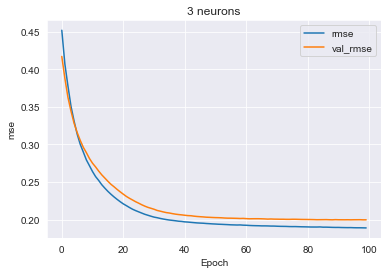

17/17 [==============================] - 0s 813us/step
MAE Train = 0.14433575940995616
RMSE Train = 0.19254982964566475
R2  = 0.03310117028606885

9/9 [==============================] - 0s 1ms/step
MAE Test = 0.13646880294051475
RMSE Test = 0.18157652677341246
R2  = -0.3263104213964274


In [36]:
# Define the loss plot
def plot_loss(history, num_neurons):
    plt.plot(history.history['root_mean_squared_error'], label='rmse')
    plt.plot(history.history['val_root_mean_squared_error'], label='val_rmse')
    # plt.ylim([0, y_lim])
    plt.xlabel('Epoch')
    plt.ylabel('mse')
    plt.legend()
    plt.title(f"{num_neurons} neurons")

    plt.grid(True)
    plt.show()

from   tensorflow.keras import layers, regularizers
from   tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
from   tensorflow.keras.optimizers import Adam

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs= X_train.shape[1]
print(f"# of inputs = {number_of_inputs}")

num_neurons = 3

# create model
model = keras.Sequential([normalizer,
                          layers.Dense(num_neurons, activation='relu', input_dim=number_of_inputs),
                          layers.Dense(num_neurons, activation='relu'),
                          layers.Dense(1, activation='linear') ])  
  
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

history = model.fit(X_train, 
                    y_train_trx,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, y_test_trx))  # Calculate validation results on 35% of the training data
                  
# Isolate and plot training curves 
hist = pd.DataFrame(history.history)
plot_loss(history, num_neurons)

# calculate metrics ---------------
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# train
y_pred = model.predict(X_train)
print(f"MAE Train = {mean_absolute_error(y_train_trx, y_pred)}")
print(f"RMSE Train = {mean_squared_error(y_train_trx, y_pred, squared=False)}")
print(f"R2  = {                 r2_score(y_train_trx, y_pred)}")
print(f"")

# holdout
y_pred = model.predict(X_test)
print(f"MAE Test = {mean_absolute_error(y_test_trx, y_pred)}")
print(f"RMSE Test = {mean_squared_error(y_test_trx, y_pred, squared=False)}")
print(f"R2  = {                r2_score(y_test_trx, y_pred)}")

TW NN neurons sweep

Epoch 1/100
17/17 [==============================] - 2s 13ms/step - loss: 0.0638 - root_mean_squared_error: 0.2525 - mean_absolute_error: 0.1623 - r_square: -0.6632 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1991 - val_mean_absolute_error: 0.1290 - val_r_square: -0.5939
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0589 - root_mean_squared_error: 0.2428 - mean_absolute_error: 0.1549 - r_square: -0.5372 - val_loss: 0.0360 - val_root_mean_squared_error: 0.1898 - val_mean_absolute_error: 0.1226 - val_r_square: -0.4494
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0547 - root_mean_squared_error: 0.2338 - mean_absolute_error: 0.1497 - r_square: -0.4255 - val_loss: 0.0331 - val_root_mean_squared_error: 0.1818 - val_mean_absolute_error: 0.1184 - val_r_square: -0.3299
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0510 - root_mean_squared_error: 0.2258 - mean_absolute_error: 0.1459 - r_square: -0.329

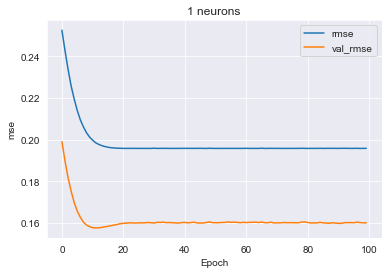

17/17 [==============================] - 0s 688us/step
MAE Train =                0.15244167523943095
RMSE Train = 0.19582143133308014
R2  =                                 -3.4996368407202993e-05

9/9 [==============================] - 0s 1ms/step
MAE Test = 0.131062083495425
RMSE Test = 0.16007270445685803
R2  = -0.030766600592238902
Epoch 1/100
17/17 [==============================] - 1s 12ms/step - loss: 0.0994 - root_mean_squared_error: 0.3152 - mean_absolute_error: 0.2092 - r_square: -1.5915 - val_loss: 0.0777 - val_root_mean_squared_error: 0.2787 - val_mean_absolute_error: 0.1793 - val_r_square: -2.1239
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0858 - root_mean_squared_error: 0.2928 - mean_absolute_error: 0.1939 - r_square: -1.2365 - val_loss: 0.0661 - val_root_mean_squared_error: 0.2570 - val_mean_absolute_error: 0.1668 - val_r_square: -1.6580
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0759 - root_mean_squared_err

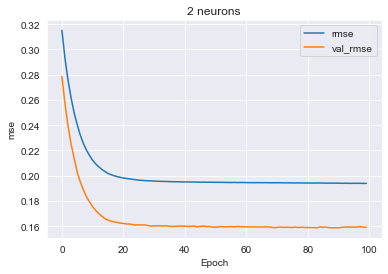

17/17 [==============================] - 0s 732us/step
MAE Train =                0.15031384981712123
RMSE Train = 0.19387756223328734
R2  =                                 0.019720641535594163

9/9 [==============================] - 0s 912us/step
MAE Test = 0.12879399773568873
RMSE Test = 0.15921513315595215
R2  = -0.019751755667431814
Epoch 1/100
17/17 [==============================] - 1s 14ms/step - loss: 0.3977 - root_mean_squared_error: 0.6307 - mean_absolute_error: 0.4378 - r_square: -9.3723 - val_loss: 0.2933 - val_root_mean_squared_error: 0.5416 - val_mean_absolute_error: 0.3404 - val_r_square: -10.7989
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.2762 - root_mean_squared_error: 0.5255 - mean_absolute_error: 0.3557 - r_square: -6.2029 - val_loss: 0.2056 - val_root_mean_squared_error: 0.4535 - val_mean_absolute_error: 0.2816 - val_r_square: -7.2717
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.1969 - root_mean_squared_e

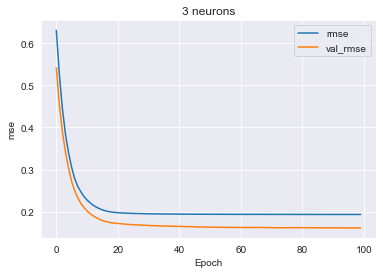

17/17 [==============================] - 0s 783us/step
MAE Train =                0.1493825936351605
RMSE Train = 0.19367345616132473
R2  =                                 0.021783548130878683

9/9 [==============================] - 0s 810us/step
MAE Test = 0.13353211713645075
RMSE Test = 0.16201754903285115
R2  = -0.05596588778269984
Epoch 1/100
17/17 [==============================] - 1s 13ms/step - loss: 0.1346 - root_mean_squared_error: 0.3668 - mean_absolute_error: 0.2988 - r_square: -2.5095 - val_loss: 1134322944.0000 - val_root_mean_squared_error: 33679.7109 - val_mean_absolute_error: 2005.8517 - val_r_square: -45631254528.0000
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.1031 - root_mean_squared_error: 0.3211 - mean_absolute_error: 0.2534 - r_square: -1.6896 - val_loss: 898728960.0000 - val_root_mean_squared_error: 29978.8086 - val_mean_absolute_error: 1785.4318 - val_r_square: -36153843712.0000
Epoch 3/100
17/17 [==============================] - 

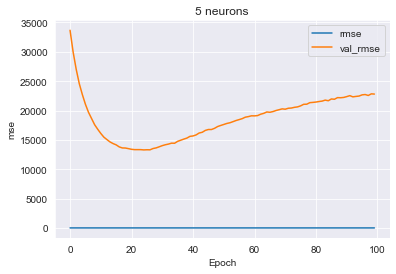

17/17 [==============================] - 0s 747us/step
MAE Train =                0.1315044334079705
RMSE Train = 0.17417364840859345
R2  =                                 0.20884850096114627

9/9 [==============================] - 0s 726us/step
MAE Test = 1358.14337829674
RMSE Test = 22804.889611453244
R2  = -20920965418.09229
Epoch 1/100
17/17 [==============================] - 1s 14ms/step - loss: 0.2088 - root_mean_squared_error: 0.4569 - mean_absolute_error: 0.3473 - r_square: -4.4454 - val_loss: 542410752.0000 - val_root_mean_squared_error: 23289.7129 - val_mean_absolute_error: 1387.1901 - val_r_square: -21819963392.0000
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1441 - root_mean_squared_error: 0.3796 - mean_absolute_error: 0.2843 - r_square: -2.7588 - val_loss: 611646784.0000 - val_root_mean_squared_error: 24731.4941 - val_mean_absolute_error: 1472.9949 - val_r_square: -24605173760.0000
Epoch 3/100
17/17 [==============================] - 0s 3ms/s

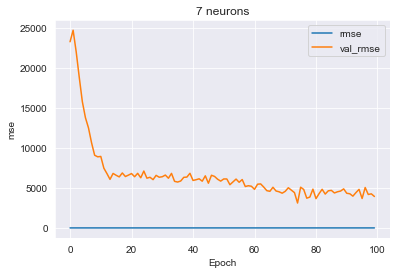

17/17 [==============================] - 0s 647us/step
MAE Train =                0.12289631370663749
RMSE Train = 0.16437359454488945
R2  =                                 0.2953736789189171

9/9 [==============================] - 0s 787us/step
MAE Test = 234.4152667131223
RMSE Test = 3934.2544669531244
R2  = -622659567.1276388
Epoch 1/100
17/17 [==============================] - 1s 12ms/step - loss: 0.2523 - root_mean_squared_error: 0.5023 - mean_absolute_error: 0.3854 - r_square: -5.5805 - val_loss: 1404228608.0000 - val_root_mean_squared_error: 37473.0391 - val_mean_absolute_error: 2231.8164 - val_r_square: -56488955904.0000
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.1479 - root_mean_squared_error: 0.3846 - mean_absolute_error: 0.2932 - r_square: -2.8582 - val_loss: 1038360064.0000 - val_root_mean_squared_error: 32223.5957 - val_mean_absolute_error: 1919.1589 - val_r_square: -41770889216.0000
Epoch 3/100
17/17 [==============================] - 0s 2m

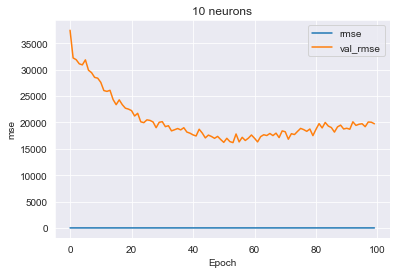

17/17 [==============================] - 0s 690us/step
MAE Train =                0.11711685563701836
RMSE Train = 0.1584946695038844
R2  =                                 0.344875142374815

9/9 [==============================] - 0s 900us/step
MAE Test = 1175.5345930443084
RMSE Test = 19738.300914454438
R2  = -15672753535.524448
Epoch 1/100
17/17 [==============================] - 1s 12ms/step - loss: 0.1799 - root_mean_squared_error: 0.4242 - mean_absolute_error: 0.3257 - r_square: -3.6921 - val_loss: 16145735.0000 - val_root_mean_squared_error: 4018.1755 - val_mean_absolute_error: 239.5378 - val_r_square: -649506560.0000
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.1135 - root_mean_squared_error: 0.3369 - mean_absolute_error: 0.2469 - r_square: -1.9606 - val_loss: 85980.5703 - val_root_mean_squared_error: 293.2244 - val_mean_absolute_error: 17.6874 - val_r_square: -3458803.7500
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.08

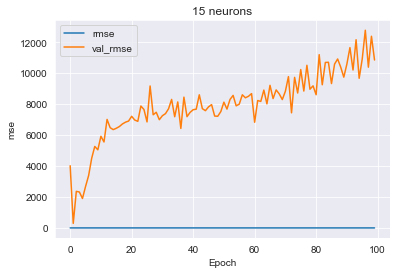

17/17 [==============================] - 0s 2ms/step
MAE Train =                0.10005513640135778
RMSE Train = 0.13660320263999415
R2  =                                 0.5133502327637718

9/9 [==============================] - 0s 793us/step
MAE Test = 646.2397778821618
RMSE Test = 10849.772091241275
R2  = -4735512681.006074


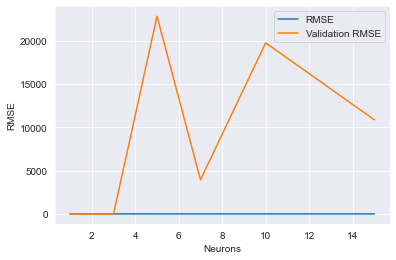

In [41]:
# Define the loss plot
def plot_loss(history):
    plt.plot(history.history['root_mean_squared_error'], label='rmse')
    plt.plot(history.history['val_root_mean_squared_error'], label='val_rmse')
    # plt.ylim([0, y_lim])
    plt.xlabel('Epoch')
    plt.ylabel('mse')
    plt.legend()
    plt.title(f"{num_neurons} neurons")

    plt.grid(True)
    plt.show()


from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization

#setup normalizer
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

number_of_inputs = X_train.shape[1]

# sweep neurons
mse_list = []
val_mse_list = []

neurons_to_try = [1, 2, 3, 5, 7, 10, 15]

for num_neurons in neurons_to_try:

    #---- pasted in model
    model = keras.Sequential([normalizer,
                            layers.Dense(num_neurons, activation='relu', input_dim=number_of_inputs),
                            layers.Dense(num_neurons, activation='relu'),
                            layers.Dense(1, activation='linear') ])

    model.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), RSquare()])

    history = model.fit(X_train, y_train_trx,
                      epochs=100,
                      batch_size=32,
                      validation_data=(X_test, y_test_trx))  # Calculate validation results on 35% of the training data

    # Isolate the metric for each epoch.
    hist = pd.DataFrame(history.history)

    #---- end model paste

    # record metrics

    current_mse = hist['root_mean_squared_error']
    current_mse = current_mse[len(current_mse)-1]  # last element is the final value
    mse_list.append(current_mse)

    current_val_mse = hist['val_root_mean_squared_error']
    current_val_mse = current_val_mse[len(current_val_mse)-1] #  last element is the final value
    val_mse_list.append(current_val_mse)

    plot_loss(history)

    # calculate metrics ---------------
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import r2_score

    # train
    y_pred_train = model.predict(X_train)
    print(f"MAE Train =                {mean_absolute_error(y_train_trx, y_pred_train)}")
    print(f"RMSE Train = {mean_squared_error(y_train_trx, y_pred_train, squared=False)}")
    print(f"R2  =                                 {r2_score(y_train_trx, y_pred_train)}")
    print(f"")

    # holdout
    y_pred_test = model.predict(X_test)
    print(f"MAE Test = {mean_absolute_error(y_test_trx, y_pred_test)}")
    print(f"RMSE Test = {mean_squared_error(y_test_trx, y_pred_test, squared=False)}")
    print(f"R2  = {                r2_score(y_test_trx, y_pred_test)}")

#plot results of sweep
plt.plot(neurons_to_try, mse_list, label='RMSE')
plt.plot(neurons_to_try, val_mse_list, label='Validation RMSE')

# plt.ylim([1,y_lim])
plt.xlabel('Neurons')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()